# Tutorial: Maximum likelihood and maximum a priori point estimation

This tutorial demonstrates how maximum likelihood estimation (MLE) and maximum a priori (MAP) inference problems
can be specified and solved using Bean Machine's variational inference. MLE is treated as a special case of MAP where
priors are uninformative, and MAP is treated as a special case of VI point estimation (i.e. with `Delta` guide distributions).

## Prerequisites

In [1]:
# Install Bean Machine in Colab if using Colab.
import sys


if "google.colab" in sys.modules and "beanmachine" not in sys.modules:
    !pip install beanmachine

In [2]:
import beanmachine.ppl as bm
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from beanmachine.ppl.distributions import Flat
from beanmachine.ppl.inference.vi import MAP

In [3]:
import os

# Plotting settings
plt.rc("figure", figsize=[8, 6])
plt.rc("font", size=14)
plt.rc("lines", linewidth=2.5)

# Manual seed
bm.seed(11)
torch.manual_seed(11)

# Other settings for the notebook.
smoke_test = "SANDCASTLE_NEXUS" in os.environ or "CI" in os.environ

## Data

Consider data following the OLS model $Y \sim N([X; 1]^\top \beta_{\text{true}}, 1.0)$.

Samples collected:   0%|          | 0/1 [00:00<?, ?it/s]

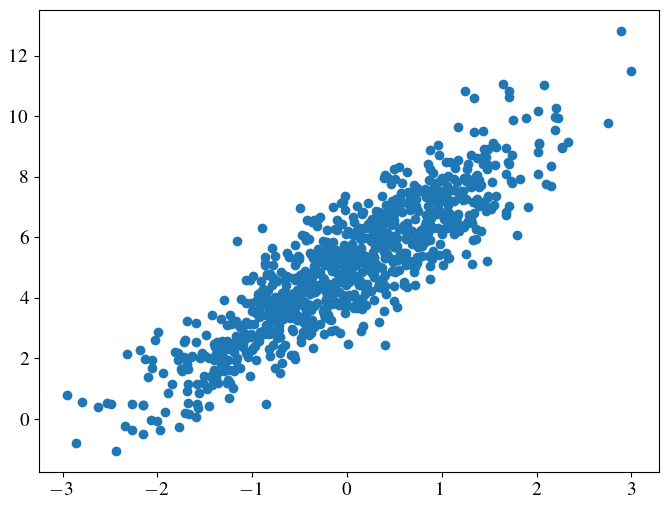

In [4]:
N = 900
true_beta = torch.tensor([2.0, 5.0])

@bm.random_variable
def X():
    return dist.Normal(0, 1).expand((N,1))

def beta():
    return true_beta

@bm.random_variable
def Y():
    return dist.Normal((torch.cat([X(), torch.ones((N,1))], dim=1) @ beta()).squeeze(), 1.0)

data = bm.simulate([X(), Y()], num_samples=1).get_chain(0)
data_X, data_Y = data[X()], data[Y()]
plt.scatter(data_X, data_Y)

## Maximum Likelihood Estimation (MLE)

By placing a `Flat` uninformative prior over $\beta$, the prior has no effect and the likelihood
and posterior become equal. Therefore, we can use MAP to search for the MLE estimate.

In [5]:
@bm.random_variable
def beta():
    return Flat(shape=(2,1))

@bm.random_variable
def Y():
    return dist.Normal((torch.cat([X(), torch.ones((N,1))], dim=1) @ beta()).squeeze(), 1.0)


v_world = MAP(
    queries=[beta()],
    observations={
        X(): data_X,
        Y(): data_Y,
    },
).infer(num_steps=1000)
with v_world:
    print(beta())

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[1.9457],
        [4.7414]], requires_grad=True)


MLE gradient deescent on linear regression has a minima we can explicitly compute using the Moore-Penrose pseudo-inverse:
$$\hat\beta_{OLS} = X^\dag y = (X^\top X)^{-1} X^\top y$$
As expected, it is close to the final iterate returned by MAP

In [6]:
torch.linalg.pinv(torch.cat([data_X, torch.ones((N,1))], dim=1)) @ data_Y

tensor([1.9489, 5.0105])

## MAP Inference

To incorporate prior beliefs, such as $\beta \sim N(0,\tau)$ in this example,
the `Flat` uninformative prior is replaced with a prior distribution that with
high precision ($\tau = \frac{1}{\sigma} = 100$) assigns the majority of probability
belief near zero. This prior results in a combined posterior which ``shrinks'' estimates
away from the MLE and back towards the prior.

In [7]:
@bm.random_variable
def beta():
    return dist.Normal(0, 0.1).expand((2,1))

@bm.random_variable
def Y():
    return dist.Normal((torch.cat([X(), torch.ones((N,1))], dim=1) @ beta()).squeeze(), 1.0)

v_world = MAP(
    queries=[beta()],
    observations={
        X(): data_X,
        Y(): data_Y,
    },
).infer(num_steps=1000)
with v_world:
    print(beta())

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[1.7403],
        [4.5078]], requires_grad=True)


It turns out some MAP estimates correspond to frequentist regularization techniques.
In the case of linear regression, MAP inference with a Normal prior is equivalent to Tikhonov or $L_2$ regularization:
$$\hat{\beta}_{L_2,\lambda} = (X^\top X + \lambda^{-2} I)^{-1} X^\top y$$

In [8]:
X_full = torch.cat([data_X, torch.ones((N,1))], dim=1)
(torch.linalg.inv(X_full.T @ X_full + 0.1**-2 * torch.eye(2)) @ X_full.T @ data_Y)

tensor([1.7403, 4.5079])